ΚΑΡΛΗΣ ΝΙΚΟΛΑΟΣ 1115201800068


ΧΑΤΖΗΠΑΥΛΟΥ ΜΑΡΙΑ 1115201400223

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [19]:
n = 5

Διάβασμα του αρχείου με μετατροπή σε dataframe

In [4]:
# read files
df = pd.read_csv('/content/gdrive/MyDrive/nasdaq2007_17.csv', header=None,sep = '\t')

df = df.reset_index(drop=True)

print("Number of rows and columns:", df.shape)

Number of rows and columns: (359, 3651)


το df.shape[0] είναι το πλήθος των γραμμών και το df.shape[1] είναι το πλήθος των στηλών. 

Αφού πρέπει να χωρίσουμε κάθε time series σε 80% training set και 20% test set βρίσκουμε σε ποιο column του dataframe αντιστοιχεί το 80% του time series που είναι το df.shape[1] * 0.8

Αποθηκεύουμε το αποτέλεσμα στην μεταβλητή percentage

In [5]:
rows = df.shape[0]
columns = df.shape[1] - 1

percentage = int(columns * 0.80)

In [6]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

Σκεφτήκαμε να εφαρμόσουμε τον κώδικα που μας δόθηκε αλλά αντί για ένα dataframe με μία στήλη με πολλές γραμμές έχουμε πολλές στήλες με πολλές γραμμές.


Ξεκινήσαμε να κάνουμε iterate κάθε γραμμή του dataframe με το iterrows(). Παρατηρήσαμε ότι με την χρήση του row εμφανίζονταν κάθετα τα δεδομένα της γραμμής, σαν στήλη, επομένως σε κάθε επανάληψη δημιουργούμε ένα temp dataframe που έχει τα time series κάθε γραμμής. Έτσι το dataframe temp είναι σαν αυτό που έχει στο παράδειγμα και μπορούμε δημιουργήσουμε σε κάθε επανάληψη τα αντίστοιχα X_train, y_train, X_test και y_test, και τα αποθηκεύουμε σε αντίστοιχες λίστες trainList και testList.

Το scale γίνεται ξεχωριστά σε κάθε γραμμή του dataframe

In [7]:
TIME_STEPS = 30
pd.options.mode.chained_assignment = None  # default='warn'

trainList = []
testList = []

for index, row in df.iterrows():
  temp = pd.DataFrame(row[1:])
  temp.columns = ['close']
  train = temp.iloc[:percentage]
  test = temp.iloc[percentage:]

  scaler = StandardScaler()
  scaler = scaler.fit(train[['close']])

  train['close'] = scaler.transform(train[['close']])
  test['close'] = scaler.transform(test[['close']])
  X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
  X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

  trainList.append([X_train, y_train])
  testList.append([X_test, y_test])

In [8]:
print(X_train.shape)

(2890, 30, 1)


In [9]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

Εκπαιδεύουμε το μοντέλο κάνοντας iterate την trainList.

Το batch_size είναι 1024 που είναι το μεγαλύτερο δυνατό επειδή κάνουμε πολλές φορές fit το μοντέλο και είναι πιο γρήγορο στην εκπαίδευση αλλά επειδή εκπαιδεύεται πολλές φορές δεν θα έχει μεγάλο πρόβλημα στην ακρίβεια του μοντέλου λόγω του μεγάλου batch_size.

Ο αριθμός των epochs είναι 5. Δεν χρειαζόμαστε πολλά epochs διότι εφαρμόζουμε το μοντέλο, 360 φορές για αυτό επιλέξαμε μικρό αριθμό, αφού θα έχουμε 1500 epochs συνολικά.

Ο αριθμός των epochs είναι 6. Δεν χρειαζόμαστε πολλά epochs διότι εφαρμόζουμε το μοντέλο, 360 φορές για αυτό επιλέξαμε μικρό αριθμό.

In [10]:
for index, mylist in enumerate(trainList):
    X_train = mylist[0]
    y_train = mylist[1]
    history = model.fit(X_train, y_train,
        epochs=6, batch_size=1024, validation_split=0.1, shuffle=False)

Epoch 1/6
3/3 [==============================] - 7s 362ms/step - loss: 0.6078 - val_loss: 1.6598
Epoch 2/6
3/3 [==============================] - 0s 29ms/step - loss: 0.5802 - val_loss: 1.3787
Epoch 3/6
3/3 [==============================] - 0s 28ms/step - loss: 0.5831 - val_loss: 1.2005
Epoch 4/6
3/3 [==============================] - 0s 24ms/step - loss: 0.5856 - val_loss: 1.1358
Epoch 5/6
3/3 [==============================] - 0s 24ms/step - loss: 0.5840 - val_loss: 1.1595
Epoch 6/6
3/3 [==============================] - 0s 24ms/step - loss: 0.5813 - val_loss: 1.2162
Epoch 1/6
3/3 [==============================] - 0s 37ms/step - loss: 0.7304 - val_loss: 0.3468
Epoch 2/6
3/3 [==============================] - 0s 23ms/step - loss: 0.6726 - val_loss: 0.2910
Epoch 3/6
3/3 [==============================] - 0s 23ms/step - loss: 0.6156 - val_loss: 0.2914
Epoch 4/6
3/3 [==============================] - 0s 23ms/step - loss: 0.6312 - val_loss: 0.3349
Epoch 5/6
3/3 [========================

In [11]:
# print(trainShape)

In [12]:
# model.save('/content/gdrive/MyDrive/modelB')

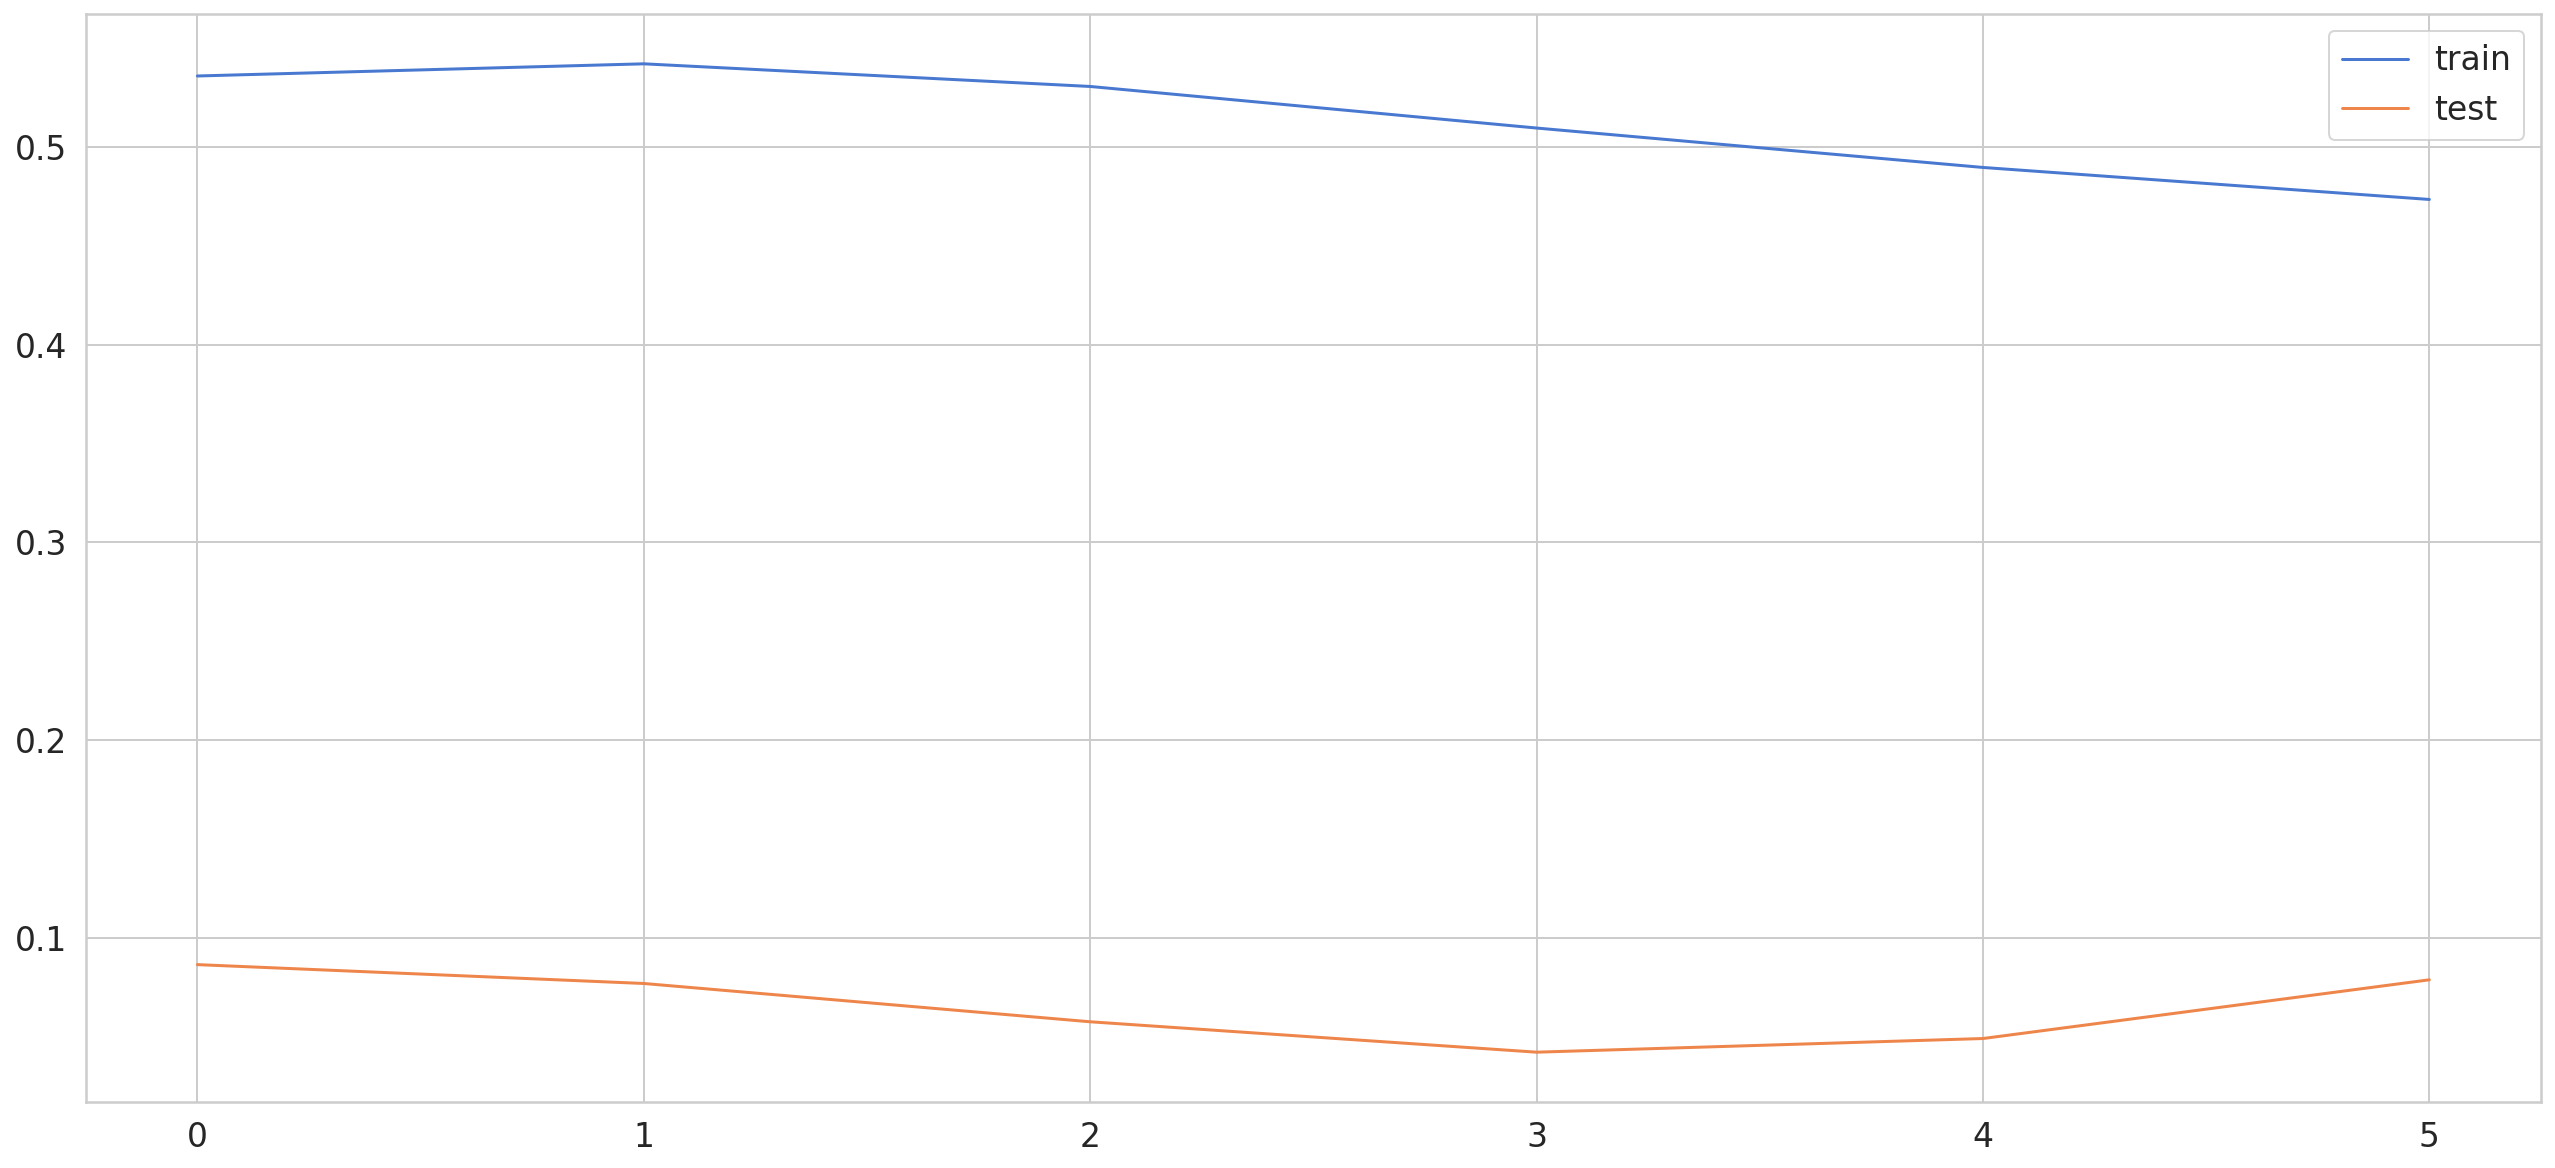

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

Με τα X_train που έχουμε αποθηκευμένα στο trainList υπολογίζουμε τα train_mae_lost για όλα τα X_train, και αποθηκεύουμε τα loss σε μια λίστα

In [14]:
train_mae_loss_list = []
for index, mylist in enumerate(trainList):
    X_train = mylist[0]
    X_train_pred = model.predict(X_train)
    train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
    train_mae_loss_list.append(train_mae_loss)
    

Κάνουμε plot train_mae_loss όπως στο παράδειγμα αλλά για τα 15 πρώτα train_mae_loss και όχι για 1 όπως στο παράδειγμα

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

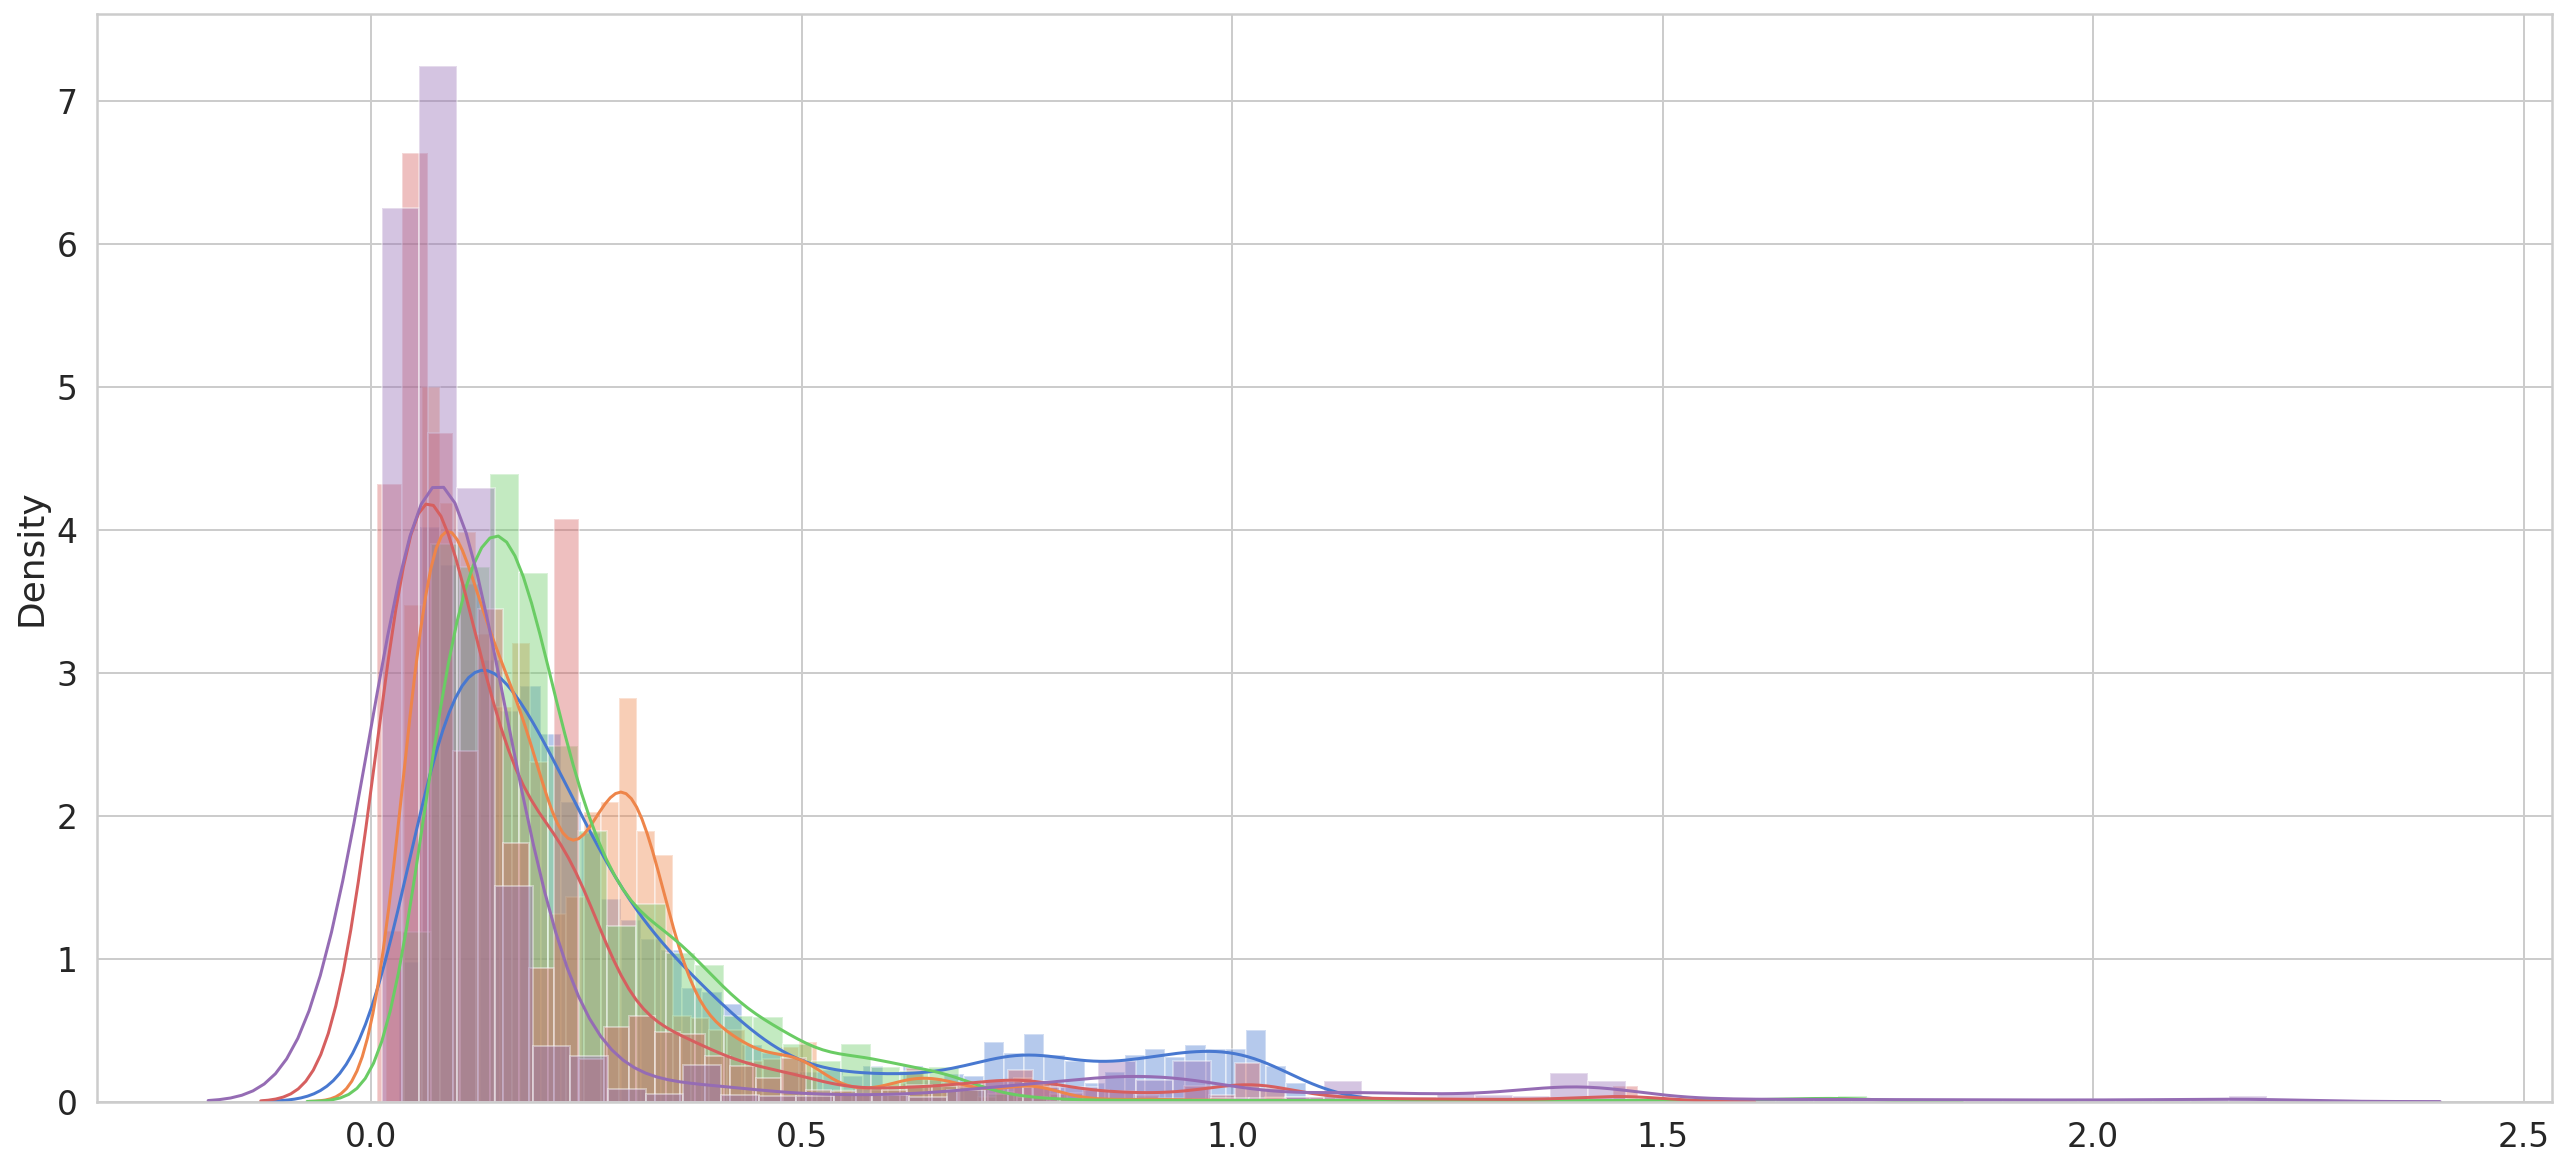

In [20]:
for index, mylist in enumerate(train_mae_loss_list):

    if(index < n):
      sns.distplot(mylist, bins=50, kde=True);


Με τα X_test που έχουμε αποθηκευμένα στο trainList υπολογίζουμε τα test_mae_lost, και αποθηκεύουμε τα loss σε μια λίστα

In [16]:
test_mae_loss_list = []
for index, mylist in enumerate(testList):
    X_test = mylist[0]
    X_test_pred = model.predict(X_test)
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
    test_mae_loss_list.append(test_mae_loss)

Βλέποντας το γράφημα διαλέξαμε ως threshold το 2.3 επειδή δεν υπάρχουν πολλα loss μεγαλύτερα από αυτό. Όταν το error είναι μεγαλύτερο από αυτό το θεωρούμε ανωμαλία.

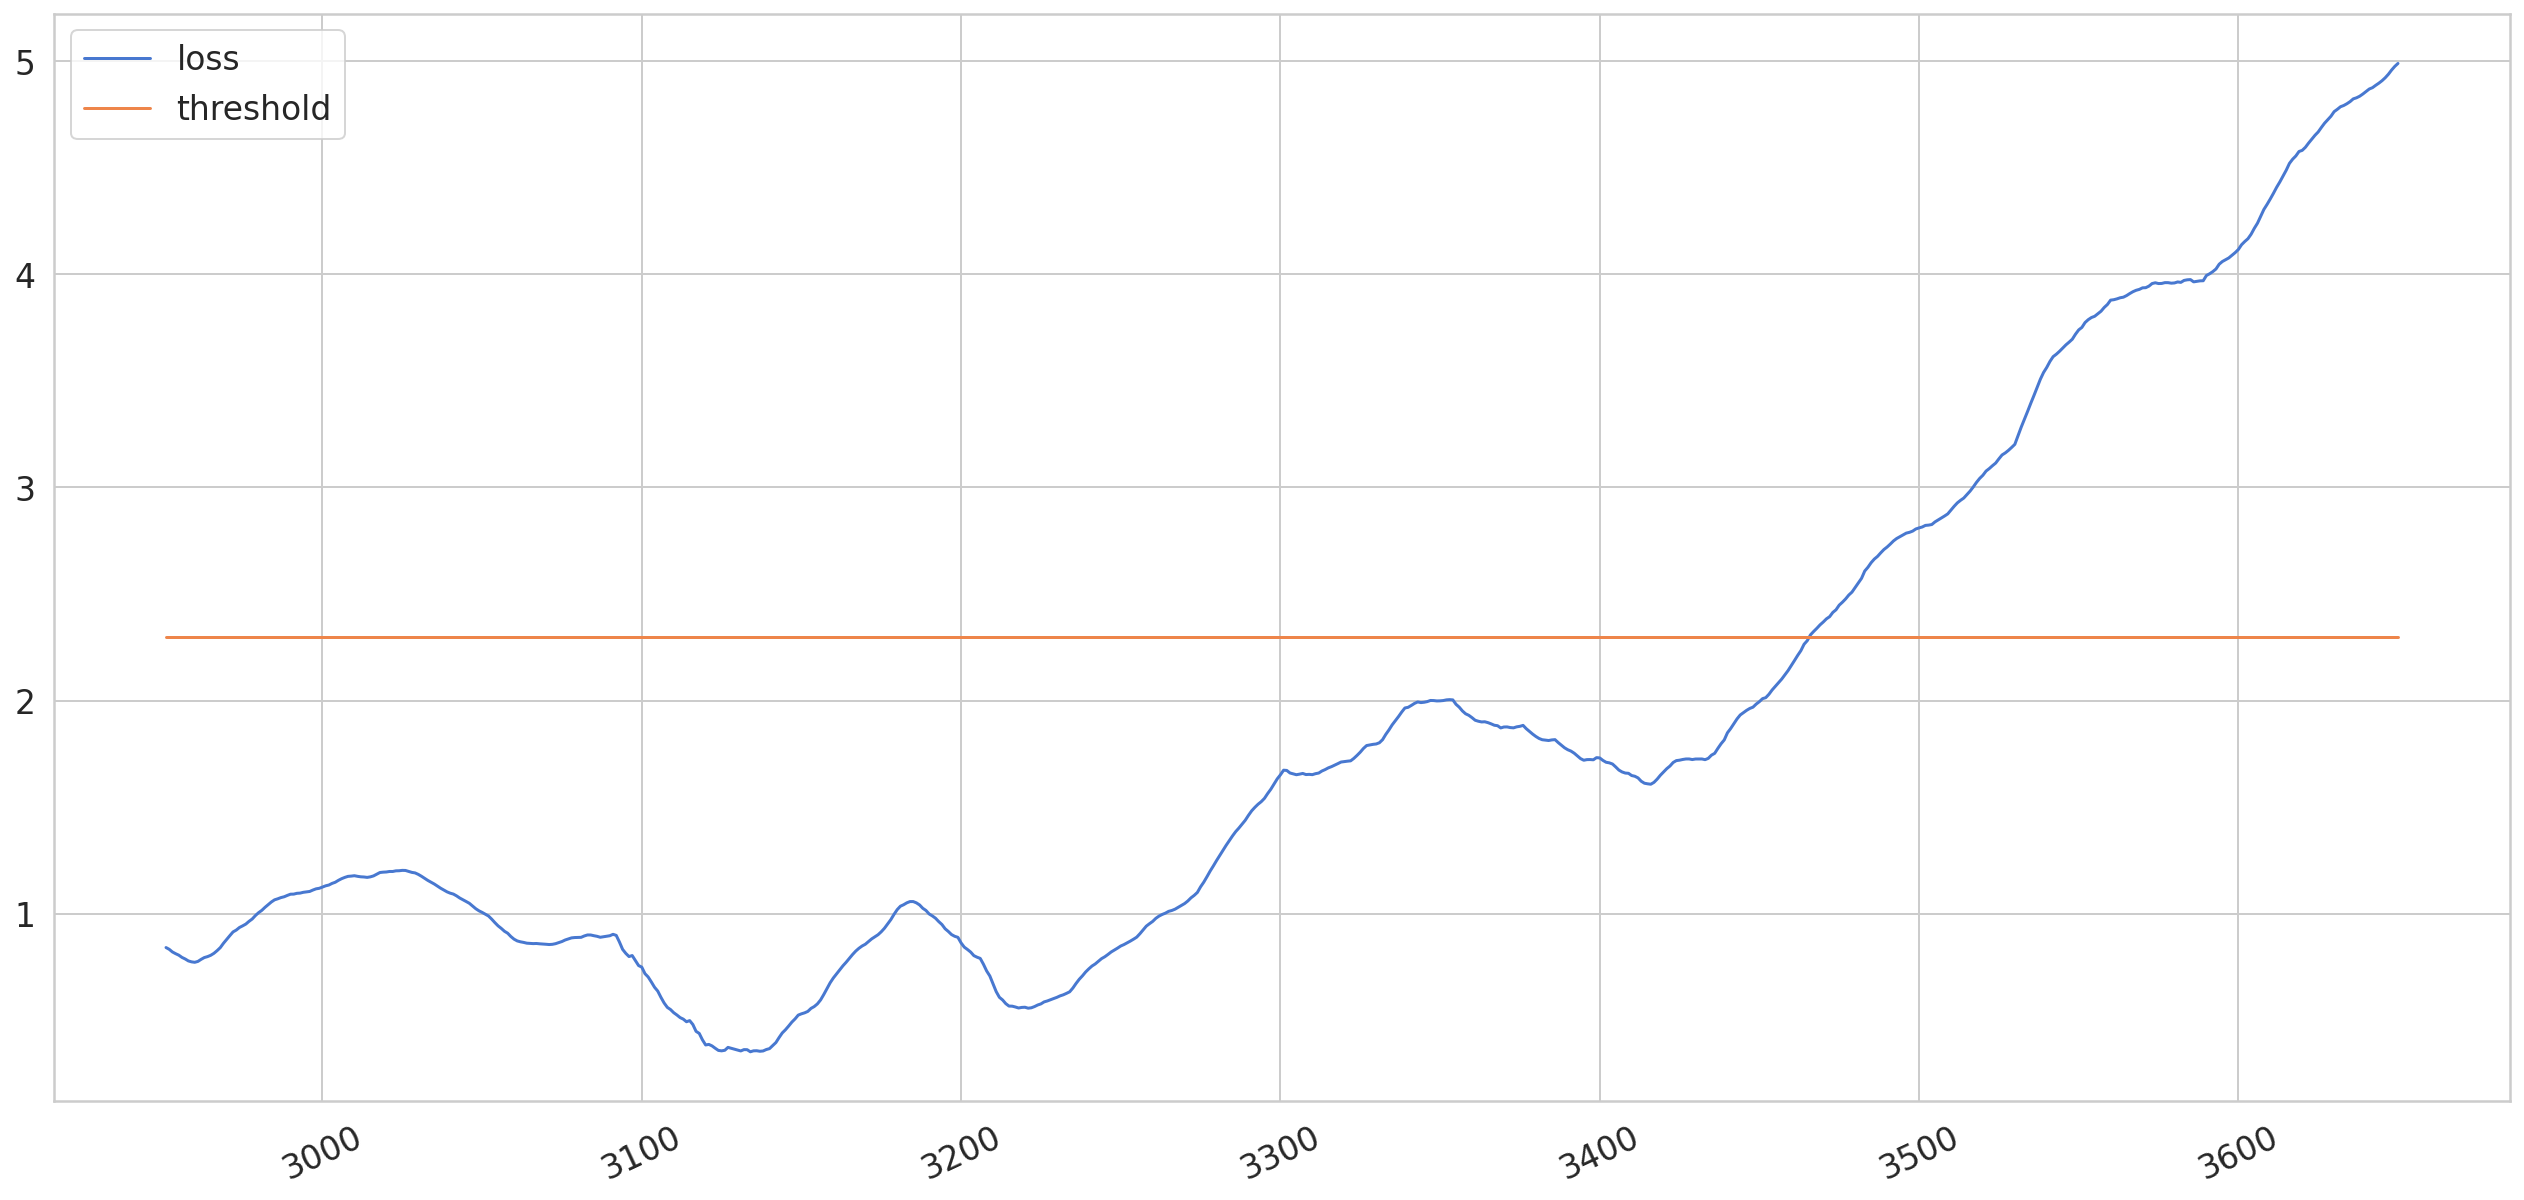

In [21]:
THRESHOLD = 2.3


for index, mylist in enumerate(test_mae_loss_list):

    # temp = pd.DataFrame(df[index][1:])
    temp = pd.DataFrame(df.loc[index][1:])
    temp.columns = ['close']
    train = temp.iloc[:percentage]
    test = temp.iloc[percentage:]
    
    scaler = StandardScaler()
    scaler = scaler.fit(train[['close']])

    train['close'] = scaler.transform(train[['close']])
    test['close'] = scaler.transform(test[['close']])

    test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
    test_score_df['loss'] = mylist
    test_score_df['threshold'] = THRESHOLD
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df['close'] = test[TIME_STEPS:].close
    
    plt.plot(test_score_df.index, test_score_df.loss, label='loss')
    plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
    plt.xticks(rotation=25)
    plt.legend();
    break

          loss  threshold  anomaly   close
3466  2.308122        2.3     True  51.006
3467  2.324198        2.3     True  50.996
3468  2.339053        2.3     True  51.125
3469  2.355176        2.3     True  51.393
3470  2.368452        2.3     True  51.313
...        ...        ...      ...     ...
3646  4.922568        2.3     True   68.22
3647  4.939194        2.3     True   68.25
3648  4.958898        2.3     True   68.11
3649  4.976037        2.3     True   67.47
3650  4.989905        2.3     True   66.81

[185 rows x 4 columns]
Empty DataFrame
Columns: [loss, threshold, anomaly, close]
Index: []
          loss  threshold  anomaly   close
3570  2.308573        2.3     True   58.45
3571  2.340430        2.3     True   58.16
3572  2.349538        2.3     True   58.15
3573  2.364842        2.3     True  58.035
3574  2.382587        2.3     True   58.91
...        ...        ...      ...     ...
3646  3.868735        2.3     True   71.71
3647  3.900623        2.3     True   72.22
3648

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

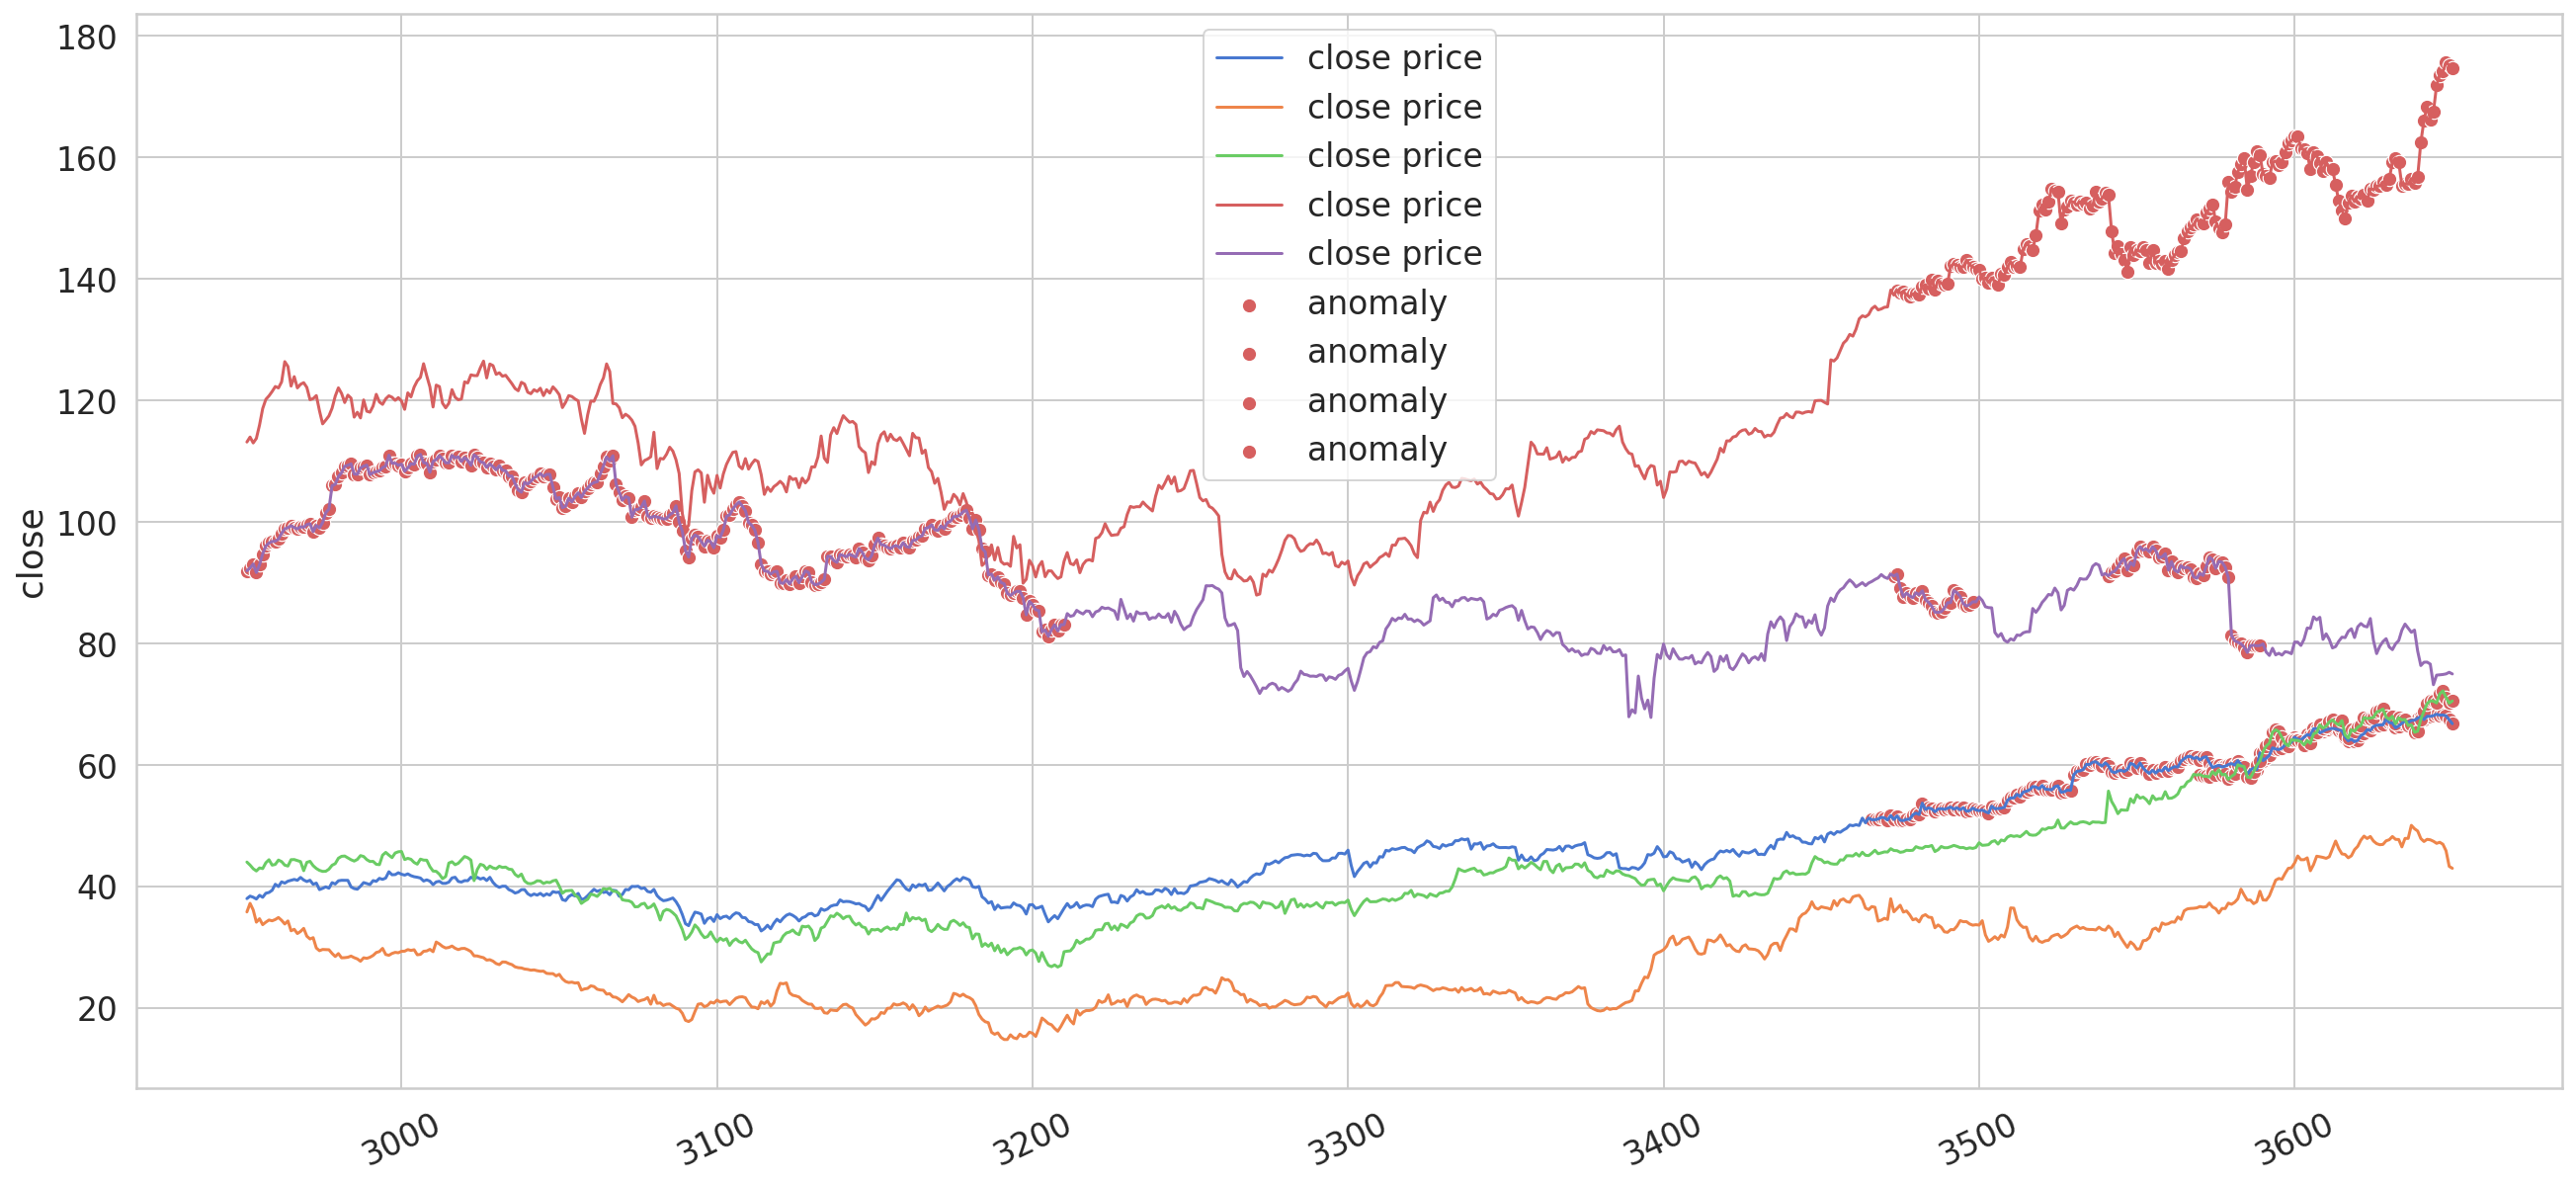

In [23]:
for index, mylist in enumerate(test_mae_loss_list):
  if(index < n):
    temp = pd.DataFrame(df.loc[index][1:])
    temp.columns = ['close']
    train = temp.iloc[:percentage]
    test = temp.iloc[percentage:]
    
    # scaler = StandardScaler()
    # scaler = scaler.fit(train[['close']])

    # train['close'] = scaler.transform(train[['close']])
    # test['close'] = scaler.transform(test[['close']])

    test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
    test_score_df['loss'] = mylist
    test_score_df['threshold'] = THRESHOLD
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df['close'] = test[TIME_STEPS:].close
    
    anomalies = test_score_df[test_score_df.anomaly == True]
    print(anomalies)
    plt.plot(
      test[TIME_STEPS:].index, 
      test[TIME_STEPS:].close, 
      label='close price'
    );
    sns.scatterplot(
      anomalies.index,
      anomalies.close,
      color=sns.color_palette()[3],
      s=52,
      label='anomaly'
    )
    plt.xticks(rotation=25)
    plt.legend();